# Test simulation MR  
For the MR equation we need the material derivative of the field at the location of the particle   
Hence we need to calculat the spacial derivative of the field and the gradients. For this I will perform   
the following tests in this notebook: 
1. test how time sampling works: how to handle sampling the field at t-delta_t and t+delta_t
1. How to choose the best value of delta_t and delta_x to calculate the gradients. 

IN this notebook I use the following nomenclature:
- dt: integration timestep partile
- Delta_t: timestep fieldset
- delta_t: sampling timestep for temporal derivative
- delta_x: spacial step for gradients
- Delta_x: gridspacing fieldset 




In [11]:
# needed packages
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from parcels import FieldSet ,ParticleSet, JITParticle, ParticleFile,Variable, AdvectionRK4,AdvectionEE
plt.style.use('../python_style_Meike.mplstyle')
from datetime import datetime, timedelta

base_directory = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/'

## Test time sampling 
I create a fieldset that is homogenous in space and increases linearly in time. I test 2 ways of loading the data (from_data and from_cdf)   
and use them in 2 simulations of a particle which samples the velocity of the field at t-delta_t and t+delta_t and is advected using advectionRK4.   
The field flows with velocity U in the x direction and U increases linearly with time.   

In [14]:
# Coordinates of the test fieldset (on A-grid)

def linear_growth_fieldset(times, udt, write_to_file = False, xdim = 201, ydim = 201, ):
    a = b = 20000 # domain size
    lon = np.linspace(-a/2, a/2, xdim, dtype=np.float32)
    lat = np.linspace(-b/2, b/2, ydim, dtype=np.float32) 
    dx, dy,dt = lon[2] - lon[1], lat[2] - lat[1], times[2]-times[1]

    # Define arrays U (zonal elocity and V (meridional velocity)
    U = np.zeros((times.size,lat.size,lon.size), dtype=np.float32)
    V = np.zeros((times.size, lat.size,lon.size), dtype=np.float32)

    for t in range(len(times)):
        time=times[t]
        U[t]=udt*time
        # if(t%2 ==0): # if you want a pulse signal velocity to test stability
        #     U[t]=1
    data = {"U": U, "V": V}
    dimensions = {"lon": lon, "lat": lat, "time": times}

    allow_time_extrapolation = False
    fieldset = FieldSet.from_data(data, dimensions, mesh = "flat", allow_time_extrapolation=allow_time_extrapolation)
    fieldset.U.interp_method = "linear"
    fieldset.V.interp_method = "linear"
    
    if(write_to_file == True):
        dset = xr.Dataset(
            data_vars=dict(U=(['time','lat','lon'],U),
                           V=(['time','lat','lon'],V)),
                           coords=dict(
                                lon=('lon',lon),
                                lat=('lat',lat),
                                time=times

                           ),
                           attrs=dict(
                               title='linear growth fieldset',
                               contact = 'm.f.bos@uu.nl')
        )
        dset.to_netcdf(base_directory+'fieldsets/linear_growth.nc')
    return fieldset

fieldsetLG= linear_growth_fieldset(times = np.arange(0,101,10), udt = 1/100, write_to_file = True)


### Making test simulation for time sampling
A test simulation that samples the time at t-1 and t=1 in a kernel
to see if this works when going to the next timestep  
This works fine for the fieldset.from_data. Now test if this also works fine if 
you read in fieldset from file instead  

In [15]:
# make custom particle class that saves t-1 and t+1

class InertialParticle(JITParticle): #
    u_t = Variable('u_t', dtype=np.float32, to_write=True, initial=0)
    u_tmin = Variable('u_tmin', dtype=np.float32, to_write=True, initial=0) 
    u_tplus = Variable('u_tplus', dtype=np.float32, to_write=True, initial=0) 
    v_t = Variable('v_t', dtype=np.float32, to_write=True, initial=0)
    v_tmin = Variable('v_tmin', dtype=np.float32, to_write=True, initial=0) 
    v_tplus = Variable('v_tplus', dtype=np.float32, to_write=True, initial=0) 
    delta_t = Variable('delta_t', dtype=np.float32, to_write=False, initial=1)

# make kernel that samples velocity at t-delta_t and t+delta_t
def kernel_sample_tmin_tplus(particle,fieldset,time):
    particle.u_tmin, particle.v_tmin = fieldset.UV[time - particle.delta_t, particle.depth, particle.lat, particle.lon]
    particle.u_t, particle.v_t = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    particle.u_tplus, particle.v_tplus = fieldset.UV[time + particle.delta_t, particle.depth, particle.lat, particle.lon]


In [16]:
# Execute simulation
x,y = 0.0, 0.0

starttime=0
endtime = 100
kernels=[kernel_sample_tmin_tplus, AdvectionRK4]
dt_timestep=3
dt_output = 3
variables = {"U": "U", "V": "V"}
dimensions = {"time":"time","lon": "lon", "lat": "lat"}
allow_time_extrapolation = False
fieldsetLGfile=FieldSet.from_netcdf(base_directory+'fieldsets/linear_growth.nc', variables, dimensions, mesh= "flat",allow_time_extrapolation=allow_time_extrapolation)
output_name1= base_directory + 'particle_simulations/lineargrowth_fieldset_from_file.zarr'
pset = ParticleSet(fieldsetLGfile, pclass = InertialParticle, lon = x, lat = y, time=starttime)
output = pset.ParticleFile(name=output_name1,outputdt=dt_output)
pset.execute( kernels, endtime=endtime, dt=dt_timestep, output_file=output)

output_name2= base_directory + 'particle_simulations/lineargrowth_fieldset_from_data.zarr'
pset2 = ParticleSet(fieldsetLG, pclass = InertialParticle, lon = x, lat = y, time=starttime)
output2 = pset2.ParticleFile(name=output_name2,outputdt=dt_output)
pset2.execute( kernels, endtime=endtime, dt=dt_timestep, output_file=output2)

INFO: Output files are stored in /storage/shared/oceanparcels/output_data/data_Meike/MR_advection/particle_simulations/lineargrowth_fieldset_from_file.zarr.
100%|██████████| 100.0/100.0 [00:03<00:00, 27.29it/s]
INFO: Output files are stored in /storage/shared/oceanparcels/output_data/data_Meike/MR_advection/particle_simulations/lineargrowth_fieldset_from_data.zarr.
100%|██████████| 100.0/100.0 [00:03<00:00, 31.09it/s]


### analyse test data


#### when using fieldset from_data (for which every timestep is already loaded in memory)
Getting t-delta_t and t+delta_t values works correctly, except when you try to get t-delta_t before the start of the fieldset time.   
Be causious of this, because in this case parcels does not throw an error but instead just takes the value at the beginning of the    
fieldset. When sampling t+delta_t outsite of the domain parcels does throw an error while you use     
allow_time_extrapolation = false. which I think is what you want.  

#### when use fieldset from_netcdf
When using fieldset form_netcdf, there are only 2 time instances loaded of the fieldset. Which makes that asking for t-delta_t and t+delta_t  
is prone to incorrect results. It only gets the value of t-delta_t and t+delta_t correctly if they are inbetween the 2 fields which are loaded.   
The fields are loaded based on the integration time step of the particles dt. So that t and t+dt are always between the loaded fields.   
This means that there is no way to always sample the correct value of t-delta_t. If you sample before the first loaded timeframe of the   
fieldset it will return zero (as shown below) but it does not throw an error (so this is dangerous as it would lead to incorrect results)  
For t+delta_t the sampling goes correclty as long if delta_t <= dt. Otherwise it can also return 0 if overstepping the loaded frames.  

#### dt and Delta t
if Delta t (timestep fieldset) is not a multiple of dt (integration timestep particle) parcels ajusts the timestepping. So in my example if it at  
t=9 it ajust dt=1 and then for t=10 it uses dt=2 so that it reaches t = 12 with 2 steps instead of 1.   
This is done by https://github.com/OceanParcels/Parcels/blob/master/parcels/particleset.py line 942  




Text(0.5, 1.0, 'Fieldset from live data')

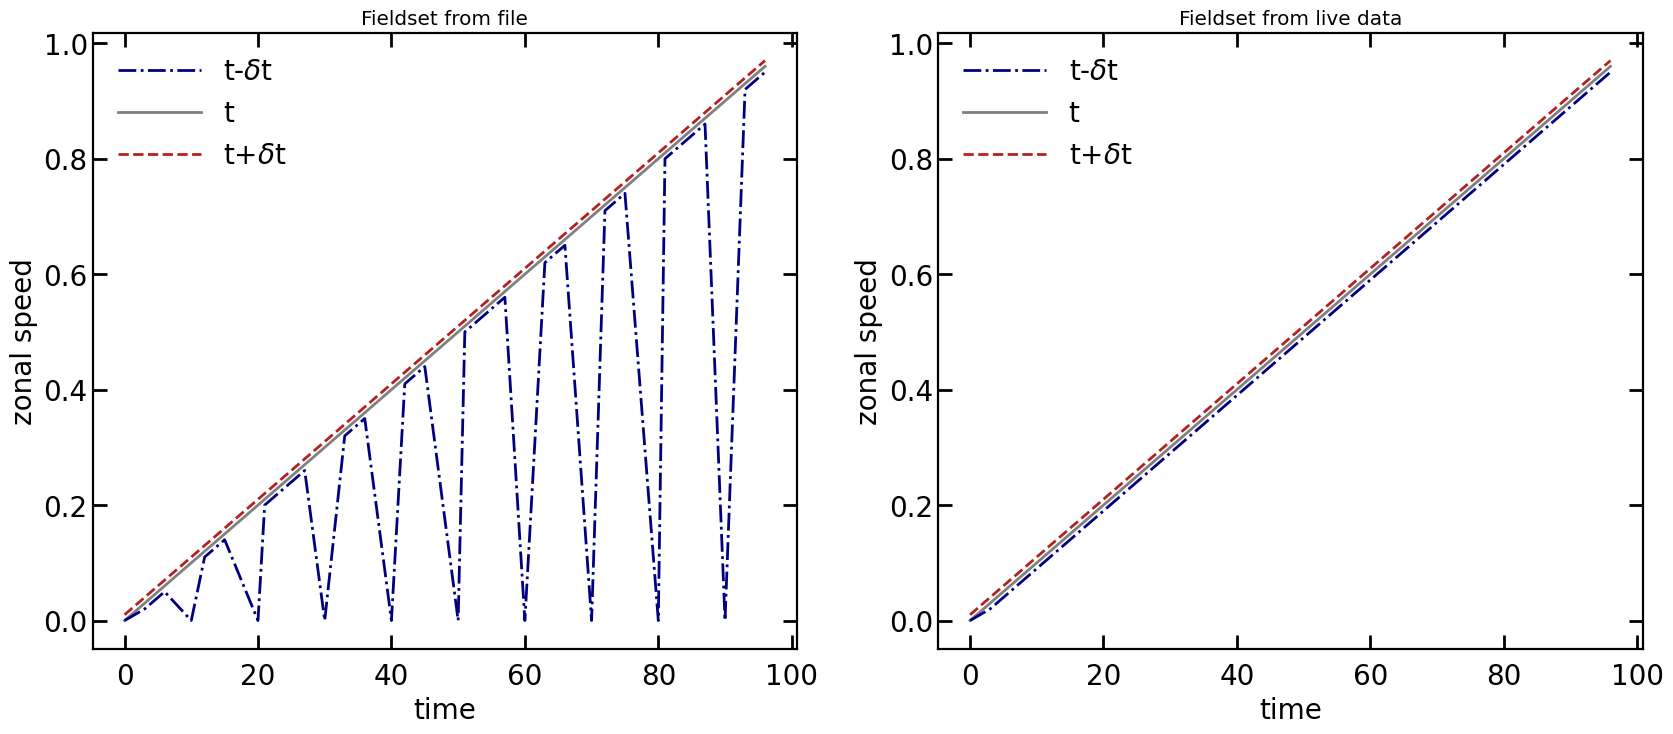

In [18]:
# read in data
dsfile = xr.open_zarr(base_directory+"particle_simulations/lineargrowth_fieldset_from_file.zarr",decode_times= False)
dsdata = xr.open_zarr(base_directory+"particle_simulations/lineargrowth_fieldset_from_data.zarr",decode_times= False)
# make plot
fig, axs = plt.subplots(1,2,figsize=(20,8))

axs[0].set_ylabel("zonal speed")
axs[0].set_xlabel("time")


axs[0].plot(dsfile['time'][0].values,dsfile["u_tmin"][0].values,'-.',color='navy',zorder=20)
axs[0].plot(dsfile['time'][0].values,dsfile["u_t"][0].values,'-',color='grey')
axs[0].plot(dsfile['time'][0].values,dsfile["u_tplus"][0].values,'--',color='firebrick')
axs[0].legend(['t-$\\delta$t','t','t+$\\delta$t'])
axs[0].set_title("Fieldset from file")

axs[1].set_ylabel("zonal speed")
axs[1].set_xlabel("time")


axs[1].plot(dsdata["time"][0].values,dsdata["u_tmin"][0],'-.',color='navy',zorder=20)
axs[1].plot(dsdata["time"][0].values,dsdata["u_t"][0],'-',color='grey')
axs[1].plot(dsdata["time"][0].values,dsdata["u_tplus"][0],'--',color='firebrick')
axs[1].legend(['t-$\\delta$t','t','t+$\\delta$t'])

axs[1].set_title("Fieldset from live data")



[ 0  3  6  9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57 60 63 66 69
 72 75 78 81 84 87 90 93 96]


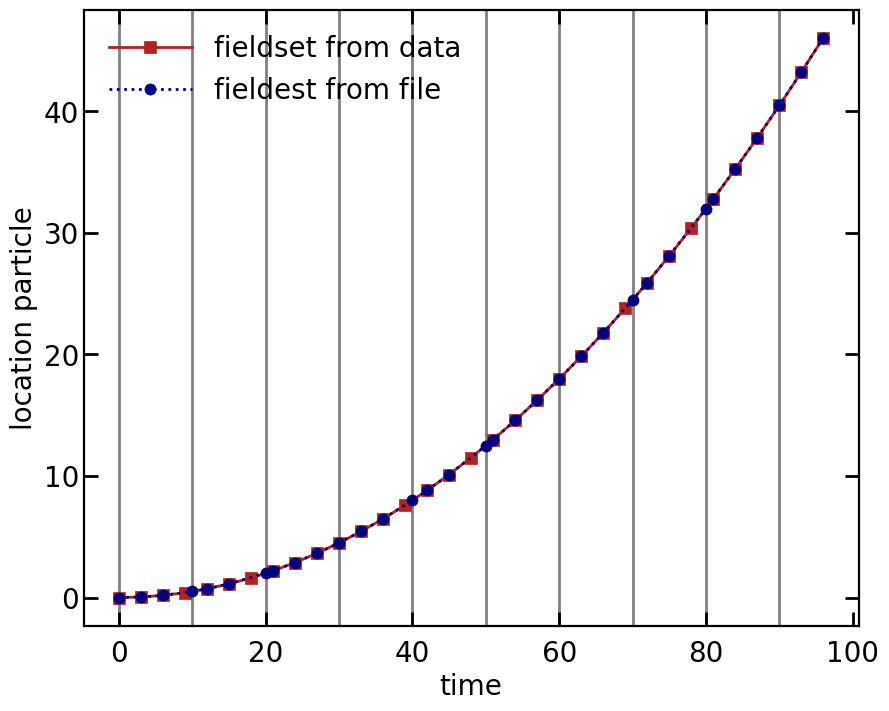

In [19]:
# particle location when using integration timestep noncommensurate with fieldset timestepping 
fig,ax=plt.subplots()
timearray=np.arange(starttime,endtime-dt_output,dt_output)
print(timearray)
ax.plot(dsdata["time"][0].values,dsdata["lon"][0].values,'-s',color='firebrick')
ax.plot(dsfile["time"][0].values,dsfile["lon"][0].values,':o',color='navy')
ax.set_ylabel('location particle')
ax.set_xlabel('time')
ax.legend(['fieldset from data','fieldest from file'])
#ax.plot(dsfile["time"][0].values,dsfile["u_t"][0].values,'--o',color='c')
for Dt in range(0,100,10):
    ax.axvline(Dt,color='gray',zorder=-5)


### Conclusion time sampling fieldset
For sampling t-delta_t and t+delta_t using the from_netcdf fieldset the following steps should be taken.   
1. the sampling of t-delta_t should always be done at the end of the previous timestep as otherwise the  
field at t-delta_t might already be removed and cannot be accesed anymore. This value of u(t-delta_t) should  
then be saved as variable ont he particle so it can be used the next timestep to calculate the derivative  
2. we can directly sample the field at t+delta_t at timestep t provided that delta_t < dt.    
3. We should alsways use an integration time step such that Delta_t%dt=0 otherwise the t-delta_t sampling   
will be something else than you expect


# Testing derivative step value
Below we test what is the best resolution to use for the derivative step.   
How to take the derivitave is something which has been considered before   
and still something which might be implemented in the future. See the   
 discussion in issue: https://github.com/OceanParcels/Parcels/issues/970    

 We will for now take the same approach as Daan did for the AdvectionDiffusion kernel   
 where a dres is manually set.    
for this we test using (a) a field that varies with a sine in space, where we use  
3 different wavelengths. (b) a field that varies given a polynomial function.   

In [20]:
# function for creating a sinosodal and polynomial velocity field
# we add a constant to the velocitiy field so that the velocity is 
# never zero and hence the particles do not converge in the to a 
# single point in the particle simulation.  


def sine_fieldset(omega, xdim = 201, ydim = 201, domain_size = 100):
    a = b = domain_size # domain size
    lon = np.linspace(-a/2, a/2, xdim, dtype=np.float32)
    lat = np.linspace(-b/2, b/2, ydim, dtype=np.float32)
    dx, dy= lon[2] - lon[1], lat[2] - lat[1]

    # Define arrays U (zonal elocity and V (meridional velocity)
    U = np.zeros((lat.size,lon.size), dtype=np.float32)
    V = np.zeros((lat.size,lon.size), dtype=np.float32)

    for nx in range(len(lon)):
        x=lon[nx]
        U[:,nx]=0.5*np.sin(omega*x)+1
    data = {"U": U, "V": V}
    dimensions = {"lon": lon, "lat": lat}

    allow_time_extrapolation = True
    fieldset = FieldSet.from_data(data, dimensions, mesh = "flat", allow_time_extrapolation=allow_time_extrapolation)
    fieldset.U.interp_method = "linear"
    fieldset.V.interp_method = "linear"
    
   
    return dx, dy, fieldset


def polynomial_fieldset(xdim = 201, ydim = 201, domain_size = 100):
    a = b = domain_size # domain size
    lon = np.linspace(-a/2, a/2, xdim, dtype=np.float32)
    lat = np.linspace(-b/2, b/2, ydim, dtype=np.float32)
    dx, dy= lon[2] - lon[1], lat[2] - lat[1]

    # Define arrays U (zonal elocity and V (meridional velocity)
    U = np.zeros((lat.size,lon.size), dtype=np.float32)
    V = np.zeros((lat.size,lon.size), dtype=np.float32)

    for nx in range(len(lon)):
        x=lon[nx]
        U[:,nx]=1-10*(x/domain_size)**2+40*(x/domain_size)**4+(x/domain_size)**3
    data = {"U": U, "V": V}
    dimensions = {"lon": lon, "lat": lat}

    allow_time_extrapolation = True
    fieldset = FieldSet.from_data(data, dimensions, mesh = "flat", allow_time_extrapolation=allow_time_extrapolation)
    fieldset.U.interp_method = "linear"
    fieldset.V.interp_method = "linear"
    
   
    return dx, dy, fieldset



In [21]:
# define particle class that saves derivatives on particles and 
# sets the dres for calculating the derivatives on each particle
# this is done so that we can test several values of dres in one
# single simulation. 
# we also define a gradient kernel that calculates the derivatives
# given the values dres of the particle. 

class InertialParticle(JITParticle):
    dudx=Variable('dudx', dtype=np.float32, to_write=True, initial=0)
    dudy=Variable('dudy', dtype=np.float32, to_write=True, initial=0)
    dvdx=Variable('dvdx', dtype=np.float32, to_write=True, initial=0)
    dvdy=Variable('dvdy', dtype=np.float32, to_write=True, initial=0)
    dres=Variable('dres', dtype=np.float32, to_write='once', initial=0)


def gradient(particle,fieldset,time):
    (u_dxm,v_dxm)=fieldset.UV[time, particle.depth, particle.lat, particle.lon-particle.dres]
    (u_dxp,v_dxp)=fieldset.UV[time, particle.depth, particle.lat, particle.lon+particle.dres]
    (u_dym,v_dym)=fieldset.UV[time, particle.depth, particle.lat-particle.dres, particle.lon]
    (u_dyp,v_dyp)=fieldset.UV[time, particle.depth, particle.lat+particle.dres, particle.lon]
    norm=1.0/(2.0*particle.dres)
    particle.dudx=(u_dxp-u_dxm)*norm
    particle.dudy=(u_dyp-u_dym)*norm
    particle.dvdx=(v_dxp-v_dxm)*norm
    particle.dvdy=(v_dyp-v_dym)*norm
    
    

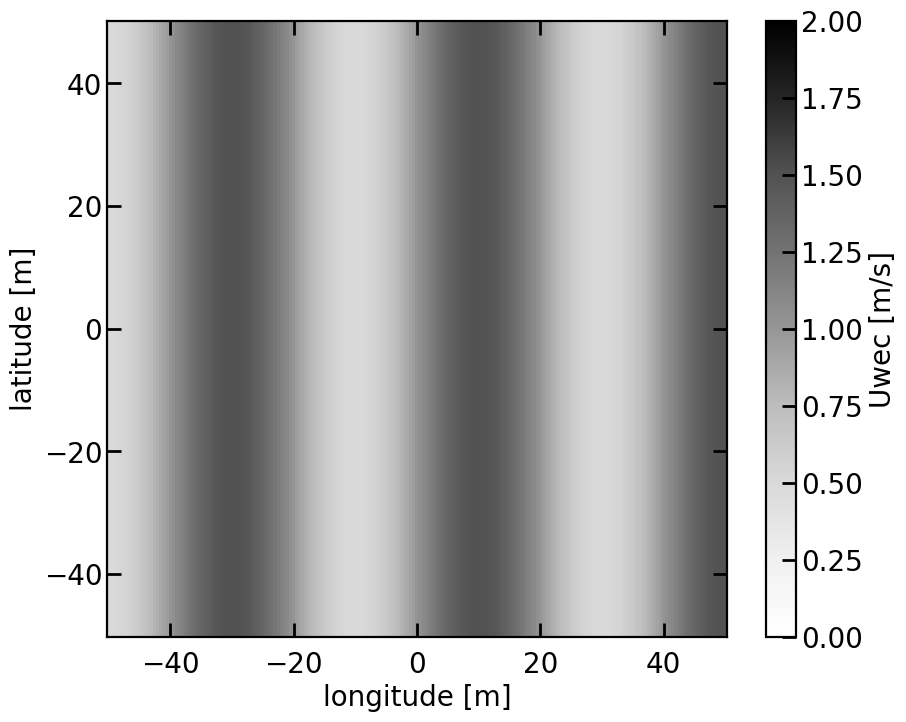

In [31]:
#create sine fieldsets
fieldset_sine = {}
omeganumbers = np.array([1,10,20])
for omeganumber in omeganumbers:
    fieldset_sine[omeganumber] = {}
    dx, dy, fieldset_sine[omeganumber] = sine_fieldset(omega= np.pi/omeganumber)

#plot fielset
omeganumber = 20
fieldset_sine[omeganumber].computeTimeChunk()
fig, ax = plt.subplots()
flowfield= fieldset_sine[omeganumber].U.data[0, :, :]
a = b = 100
xdim = ydim =201
lon = np.linspace(-a/2, a/2, xdim, dtype=np.float32)
lat = np.linspace(-b/2, b/2, ydim, dtype=np.float32)
pcm=ax.pcolormesh(lon, lat, flowfield,cmap='Grays',vmin=0,vmax=2)
ax.set_xlabel("longitude [m]")
ax.set_ylabel("latitude [m]")

cbar=fig.colorbar(pcm,label='Uwec [m/s]')



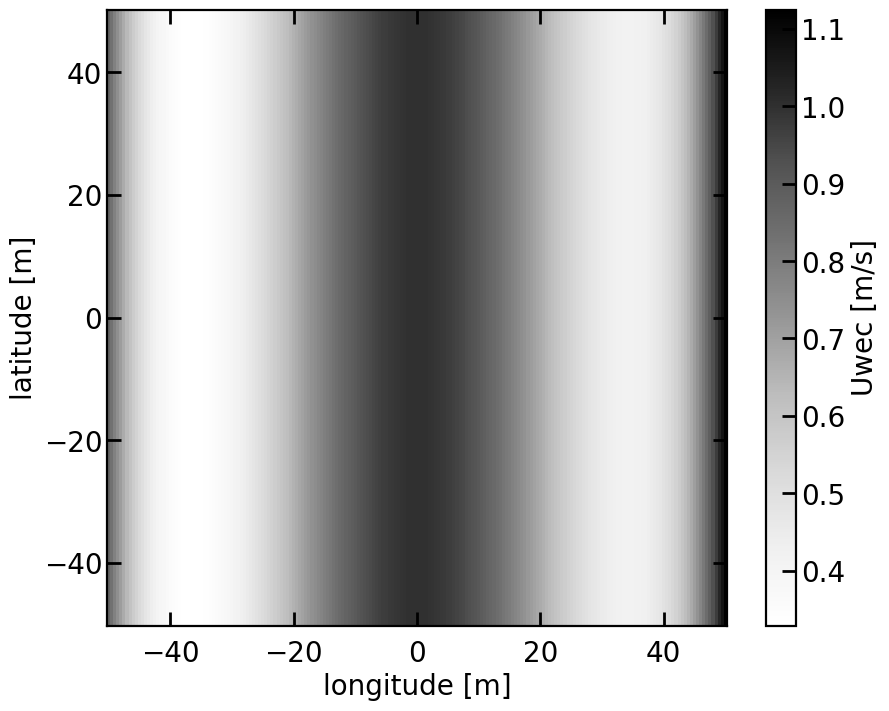

In [23]:
#create polynomial fieldset
dx, dy, fieldset_polynomial = polynomial_fieldset()


#plot fielset
fieldset_polynomial.computeTimeChunk()
fig, ax = plt.subplots()
flowfield= fieldset_polynomial.U.data[0, :, :]
a=b=100
xdim=ydim=201
lon = np.linspace(-a/2, a/2, xdim, dtype=np.float32)
lat = np.linspace(-b/2, b/2, ydim, dtype=np.float32)
pcm=ax.pcolormesh(lon, lat, flowfield,cmap='Grays')
ax.set_xlabel("longitude [m]")
ax.set_ylabel("latitude [m]")

cbar=fig.colorbar(pcm,label='Uwec [m/s]')




In [32]:
# Execute simulation for sine field with omega 2pi/001, 2pi/010, 2pi/020
dreslist=np.array([0.1,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
nparticles=dreslist.size
x = np.zeros(nparticles)-47
y = np.zeros(nparticles)-47
time = np.zeros(nparticles)
kernels=[gradient, AdvectionRK4]
dt_timestep=1
dt_output = 1
runtime= 100
variables = {"U": "U", "V": "V"}
dimensions = {"time":"time","lon": "lon", "lat": "lat"}

omeganumbers = np.array([1,10,20])

for omeganumber in omeganumbers:
    pset = ParticleSet.from_list(fieldset_sine[omeganumber], pclass = InertialParticle, lon = x, lat = y, time=time, dres=dreslist*dx)

    output = pset.ParticleFile(name=base_directory+"particle_simulations/sine_flowdres_omega{:03d}.zarr".format(omeganumber),outputdt=dt_output)
    pset.execute( kernels, runtime=runtime, dt=dt_timestep, output_file=output)



INFO: Output files are stored in /storage/shared/oceanparcels/output_data/data_Meike/MR_advection/particle_simulations/sine_flowdres_omega001.zarr.
100%|██████████| 100.0/100.0 [00:11<00:00,  8.63it/s]
INFO: Output files are stored in /storage/shared/oceanparcels/output_data/data_Meike/MR_advection/particle_simulations/sine_flowdres_omega010.zarr.
100%|██████████| 100.0/100.0 [00:12<00:00,  8.25it/s]
INFO: Output files are stored in /storage/shared/oceanparcels/output_data/data_Meike/MR_advection/particle_simulations/sine_flowdres_omega020.zarr.
100%|██████████| 100.0/100.0 [00:12<00:00,  7.72it/s]


In [33]:
#execute simulation polynomial field

nparticles=dreslist.size
x = np.zeros(nparticles)-47
y = np.zeros(nparticles)-47
time = np.zeros(nparticles)

kernels=[gradient, AdvectionRK4]
dt_timestep=1
dt_output = 1
runtime= 100
variables = {"U": "U", "V": "V"}
dimensions = {"time":"time","lon": "lon", "lat": "lat"}

pset = ParticleSet.from_list(fieldset_polynomial, pclass = InertialParticle, lon = x, lat = y, time=time, dres=dreslist*dx)

output = pset.ParticleFile(name=base_directory+"particle_simulations/polynomial_flowdres.zarr",outputdt=dt_output)
pset.execute( kernels, runtime=runtime, dt=dt_timestep, output_file=output)



INFO: Output files are stored in /storage/shared/oceanparcels/output_data/data_Meike/MR_advection/particle_simulations/polynomial_flowdres.zarr.
100%|██████████| 100.0/100.0 [00:11<00:00,  8.37it/s]


In [34]:
#load in particle dataset from the simulations

dataset={}
omeganumberlist=[1,10,20]
for omeganumber in omeganumberlist:
    dataset[omeganumber]=xr.open_zarr(base_directory+"particle_simulations/sine_flowdres_omega{:03d}.zarr".format(omeganumber))

dataset['poly']=xr.open_zarr(base_directory+"particle_simulations/polynomial_flowdres.zarr".format(omeganumber))


<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_1379277/2966624280.py:19: SyntaxWarning: invalid escape sequence '\o'
  ax.set_title('$\omega = 2 \pi/$'+'{:d} '.format(omeganumber))


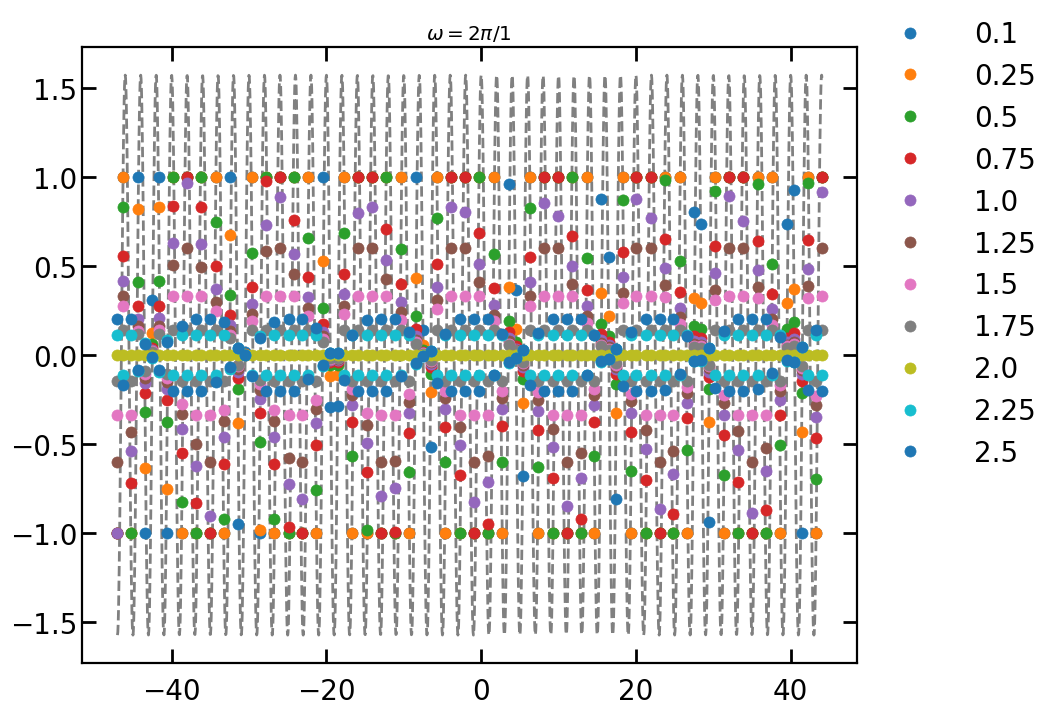

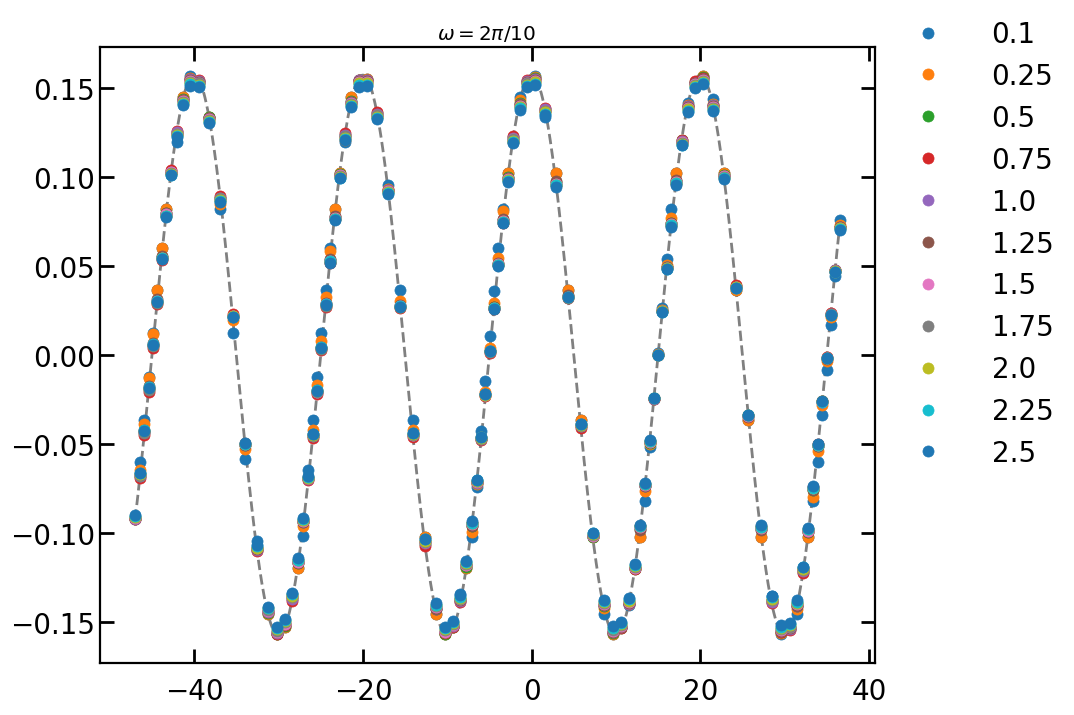

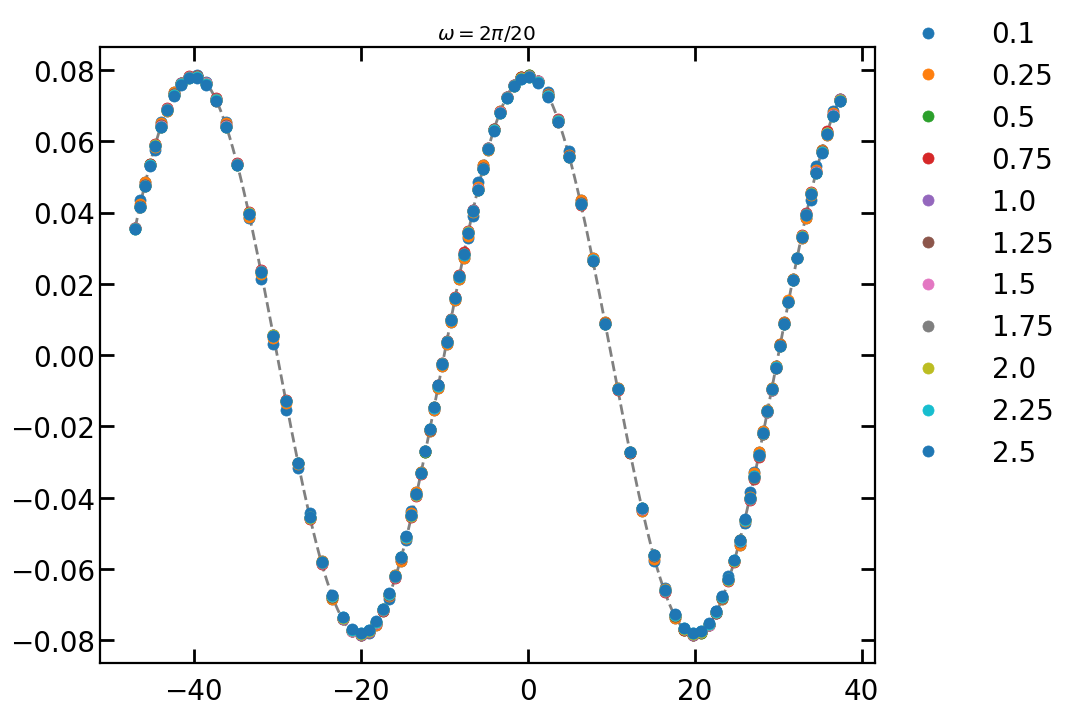

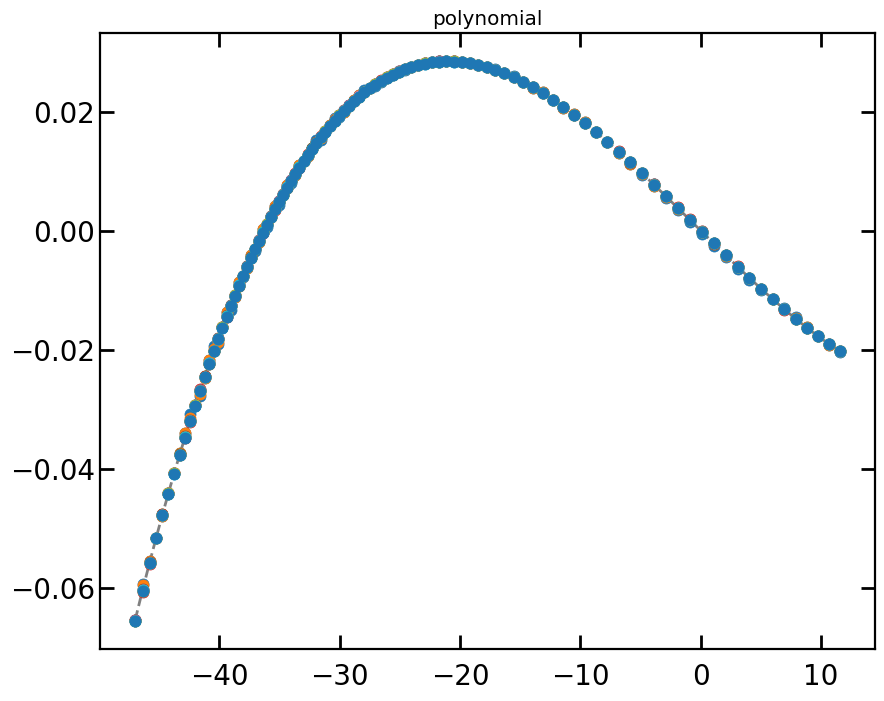

In [35]:
# compare derivatives calculated in the parcels simulation
# with the analytical expressions for the derivatives of
# the field

def analytical_derivative_sine(omega, x):
    return omega*0.5*np.cos(omega*x)


def analytical_derivative_polynomial(X, x):
    return -(20/X)*(x/X)+(160/X)*(x/X)**3+(3./X)*(x/X)**2


for omeganumber in omeganumberlist:

    fig,ax=plt.subplots()
    omega=np.pi/omeganumber

    ax.plot(dataset[omeganumber]['lon'].values.T,dataset[omeganumber]['dudx'].values.T,'o')
    ax.set_title('$\omega = 2 \pi/$'+'{:d} '.format(omeganumber))


    xlist=np.linspace(dataset[omeganumber]['lon'][0][0].values,dataset[omeganumber]['lon'][0][-1].values, 2000)

    ax.legend(dreslist,loc=(1,0.3))
    ax.plot(xlist,analytical_derivative_sine(omega,xlist),'--',color='grey',zorder=-20)

fig,ax=plt.subplots()
ax.plot(dataset['poly']['lon'].values.T,dataset['poly']['dudx'].values.T,'o')
ax.set_title('polynomial')
xlist=np.linspace(dataset['poly']['lon'][0][0].values,dataset['poly']['lon'][0][-1].values, 2000)
ax.plot(xlist,analytical_derivative_polynomial(100,xlist),'--',color='grey',zorder=-20)





Text(0, 0.5, 'error/total error')

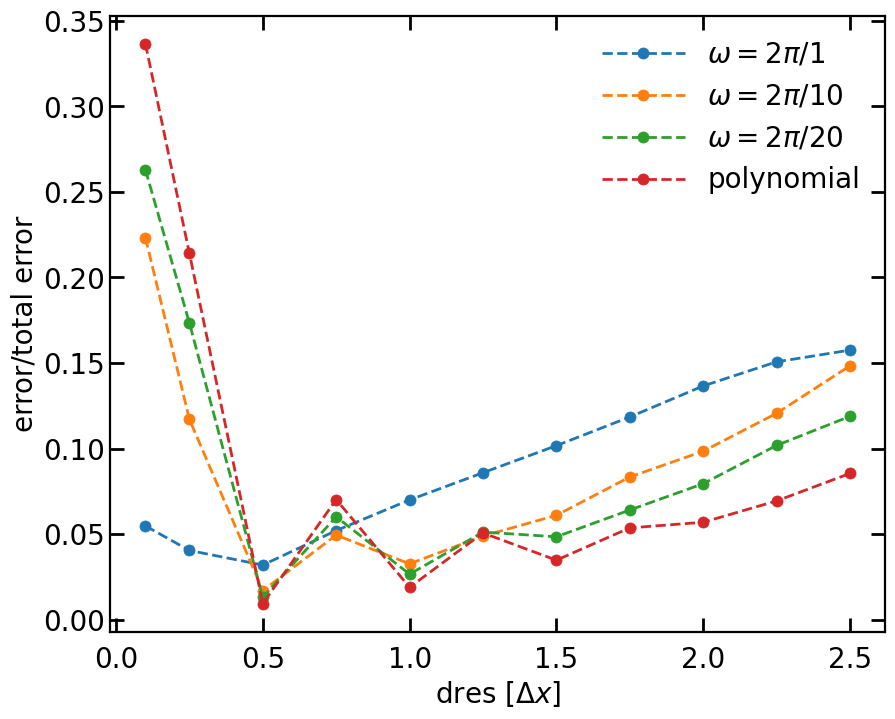

In [36]:
# Calculate the normalized error as function of
# dres for the different fieldsets tested here
# the error is normalized by the sum of the total 
# error for each fieldset. 

fig1,ax1=plt.subplots()
legend=[]
for omeganumber in omeganumberlist:
    error=np.zeros(dreslist.size)
    i=0
    omega=np.pi/omeganumber
    for dres in dreslist:
        error[i]=np.sum(np.abs(dataset[omeganumber]['dudx'][i].values-analytical_derivative_sine(omega,dataset[omeganumber]['lon'][i].values)))
        i+=1
    #xlist=np.linspace(datasets[int(dres*1000)]['lon'][0][0],datasets[int(dres*1000)]['lon'][0][-1], 2000)
    legend.append('$\\omega = 2 \\pi/$'+'{:d} '.format(omeganumber))
    totalsum=np.sum(error)
    ax1.plot(dreslist,error/totalsum,'--o')


#add poly
error=np.zeros(dreslist.size)
i=0
for dres in dreslist:
    error[i]=np.sum(np.abs(dataset['poly']['dudx'][i].values-analytical_derivative_polynomial(100,dataset['poly']['lon'][i].values)))
    i+=1
#xlist=np.linspace(datasets[int(dres*1000)]['lon'][0][0],datasets[int(dres*1000)]['lon'][0][-1], 2000)
legend.append('polynomial')
totalsum=np.sum(error)
ax1.plot(dreslist,error/totalsum,'--o')
ax1.legend(legend)
ax1.set_xlabel('dres [$\\Delta x$]')
ax1.set_ylabel('error/total error')
#ax1.set_yscale('log')

## Conclusion
A using a step of delta_x =0.5 Delta_x gives the smallest error and hence we use this for the horizontal level and for timestepping.   
For the vertical level we have to make sure that we do not step outside to domain when calculating the derivatives at the bottom/surface  
of the ocean and we should think how to deal with \Delta_z varying with depth. For this we might want to use: particle.zi[0] and for  
the time stepping we might want to look into field.U.time_index(time)
